In [93]:
%%capture
!pip install pandas
!pip install scipy
!pip install matplotlib
!pip install seaborn
!pip install tensorflow
import zipfile
import os
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
import requests

## imports for preprocessing
!pip install -U scikit-learn
!pip install nltk
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('all')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

#imports for sentiment analysis
from nltk.corpus import sentiwordnet as swn
from nltk.corpus import wordnet as wn
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag

#imports for graphs
import matplotlib.pyplot as plt

#imports for model prediction
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, precision_score, classification_report, recall_score
import warnings
from pandas.errors import SettingWithCopyWarning
import joblib
import tensorflow as tf
import os


#Imports for Bert
!pip install transformers umap-learn hdbscan scikit-learn pandas
import torch
from transformers import BertTokenizer, BertModel
import umap
import hdbscan
from sklearn.linear_model import LogisticRegression
!pip install bertopic
!pip install tf_keras
from bertopic import BERTopic

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [94]:
##Accessing a CSV
uploaded_zip = '/home/spope/EclipsePlatform/eclipse_platform.zip'
extract_dir = '/home/spope/EclipsePlatform/extracted'
if not os.path.exists(extract_dir):
    os.makedirs(extract_dir)
with zipfile.ZipFile(uploaded_zip, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

csv_file = os.path.join(extract_dir, 'eclipse_platform.csv')
fulldata = pd.read_csv(csv_file)

In [95]:
# Split the data into training and test sets
def SplitData(dataset):
        train_size = int(0.8 * len(dataset))
        test_size = len(dataset) - train_size
        trainset, testset = dataset[:train_size], dataset[train_size:]
        return trainset, testset

In [149]:
class TimeSet:
    def CreateDuration(dataset):
        dataset['Created_time'] = pd.to_datetime(dataset['Created_time'], utc=True)
        dataset['Resolved_time'] = pd.to_datetime(dataset['Resolved_time'], utc=True)

        # Convert to the desired format
        dataset['Created_time2'] = dataset['Created_time'].dt.strftime('%m/%d/%Y %H:%M')
        dataset['Resolved_time2'] = dataset['Resolved_time'].dt.strftime('%m/%d/%Y %H:%M')

        # Parse the formatted datetime strings back to datetime objects to ensure they are in the correct format
        dataset['Created_time2'] = pd.to_datetime(dataset['Created_time2'], format='%m/%d/%Y %H:%M')
        dataset['Resolved_time2'] = pd.to_datetime(dataset['Resolved_time2'], format='%m/%d/%Y %H:%M')

        # Calculate the duration in hours
        dataset['Duration'] = dataset['Resolved_time2'] - dataset['Created_time2']
        dataset['Duration_hours'] = dataset['Duration'].dt.total_seconds() / 3600

        # Drop the intermediate columns
        dataset.drop(['Created_time2', 'Resolved_time2', 'Duration'], axis=1, inplace=True)
    
    def NoOutliers(df):
        Q1 = df['Duration_hours'].quantile(0.25)
        Q3 = df['Duration_hours'].quantile(0.75)

        # Calculate the IQR
        IQR = Q3 - Q1

        # Define the lower and upper bounds for filtering outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Filter out the outliers
        df = df[(df['Duration_hours'] >= lower_bound) & (df['Duration_hours'] <= upper_bound)]
        return(df)
    def CreateTimeLabel(df):
        threshold = df['Duration_hours'].quantile(0.70)

    # Create a new column TimeLabel based on the threshold
        df['TimeLabel'] = df['Duration_hours'].apply(lambda x: 'short' if x <= threshold else 'long')
        df = df[df['Resolution'] == 'FIXED']
        return df

In [97]:
class Preprocessing:
    def RemoveStopWords(dataset):
        #making all the items in the descriptions columns lower
        dataset['Description'] = dataset['Description'].str.lower()
        # Define stop words
        stop_words = set(stopwords.words('english'))
         # Remove stop words
        for index, row in dataset.iterrows():
            # Check if the 'Description' is not NaN
            if isinstance(row['Description'], str):
                words = row['Description'].split()
                final_tokens = [word for word in words if word not in stop_words]
                dataset.at[index, 'Description'] = ' '.join(final_tokens)
    
        return dataset
    def Lemmitization(dataset):
        # Initialize the WordNet Lemmatizer
        lemmatizer = WordNetLemmatizer()
        # Function to lemmatize a sentence
        def lemmatize_sentence(sentence):
            words = nltk.word_tokenize(sentence)
            lemmatized_words = [lemmatizer.lemmatize(word, pos='v') for word in words]  # Lemmatize verbs (default)
            return ' '.join(lemmatized_words)
        dataset['Description'] = dataset['Description'].astype(str)  # Convert all to strings

        # Apply lemmatization to each row in the 'Description' column
        dataset['Description'] = dataset['Description'].apply(lemmatize_sentence)


In [98]:
class SentimentAnalysis:
    def get_wordnet_pos(treebank_tag):
          if treebank_tag.startswith('J'):
            return wn.ADJ
          elif treebank_tag.startswith('V'):
            return wn.VERB
          elif treebank_tag.startswith('N'):
            return wn.NOUN
          elif treebank_tag.startswith('R'):
            return wn.ADV
          else:
            return None
    # Function to calculate sentiment scores
    def CalculateSentimentScores(description):
        tokens = word_tokenize(description)
        tagged_tokens = pos_tag(tokens)
        
        pos_score = 0
        neg_score = 0
        token_count = 0
    
        for word, tag in tagged_tokens:
            wn_tag = SentimentAnalysis.get_wordnet_pos(tag)
            if wn_tag not in (wn.NOUN, wn.ADJ, wn.ADV):
                continue
        
            synsets = list(swn.senti_synsets(word, wn_tag))
            if not synsets:
                continue
        
            # Use the first synset for simplicity
            synset = synsets[0]
            pos_score += synset.pos_score()
            neg_score += synset.neg_score()
            token_count += 1
    
        # Normalize scores by the number of tokens
        if token_count > 0:
            pos_score /= token_count
            neg_score /= token_count
            return pos_score, neg_score
    # Apply sentiment score calculation to each description
    def CreatePosNegColumns(dataset): 
        dataset[['Pos_Score', 'Neg_Score']] = dataset['Description'].apply(lambda x: pd.Series(SentimentAnalysis.CalculateSentimentScores(x)))
    #Creating a column for Emotion (Positive or Negative)
    def EmotionColumn(dataset):
        #Creating a column for binary emotion (positive or negative)
        dataset['Emotion'] = dataset['Pos_Score'] - dataset['Neg_Score']
    
        # Assign labels based on the difference
        dataset['Emotion'] = dataset['Emotion'].apply(lambda x: 'positive' if x > 0 else 'negative')
    def EmotionalityColumn(dataset):
        dataset['Emotionality'] = dataset['Pos_Score']+ dataset['Neg_Score']

In [99]:
def Destiny(df):
    # Create a new column 'Destiny' with default value 'Not Fixed'
    df['Destiny'] = 'Not Fixed'
    
    # Update 'Destiny' based on conditions in 'Resolution' column
    df.loc[df['Resolution'] == 'FIXED', 'Destiny'] = 'Fixed'
    return df

In [100]:
class FeatureEncoding:
    def Emotion(df):
    #Label Positive emotion at 1 and negative as 0
        df['Emotion'] = df['Emotion'].map({'positive': 1, 'negative': 0})
    def Priority(df):
        # Label Priority Columns numerically
        df['Priority'] = df['Priority'].map({'P1': 1, 'P2': 2, 'P3': 3, 'P4': 4, 'P5': 5})
    def DropDescriptionNA(df):
        df = df[df['Description'] != 'nan']

In [101]:
class BertTopic:
    def Model(df):
        model = BERTopic(nr_topics="10")

        # Prepare the documents
        docs = df['Description'].fillna('').astype(str).tolist()

        # Fit the model to your data
        topics, probabilities = model.fit_transform(docs)
        #adding a column for predicted topics
        new_docs = df['Description'].fillna('').astype(str).to_list()
        topics, probs = model.transform(new_docs)
        df['Predicted_Topic'] = topics
        return df

In [102]:
def MLPModelTest(df, input_column, target_column, vectorizer_path, model_path):
    if isinstance(input_column, str):
        input_column = [input_column]
    # Concatenate input columns to form the feature set
    X = df[input_column].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
    y = df[target_column]  # Target variable
    
    # Load the pre-trained model and vectorizer
    model = joblib.load(model_path)
    vectorizer = joblib.load(vectorizer_path)
    
    # Vectorize the text data
    X_vec = vectorizer.transform(X)
    
    # Make predictions
    predictions = model.predict(X_vec)
    
    # Calculate accuracy and F1 score
    accuracy = accuracy_score(y, predictions)
    f1 = f1_score(y, predictions, average='weighted')
    precision = precision_score(y, predictions, average='weighted')
    recall = recall_score(y, predictions, average='weighted')
    print(f"Accuracy: {accuracy:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall:.2f}")
    report = classification_report(y, predictions)
    print(report)


In [158]:
import pandas as pd
import joblib
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

def CNNModelTest(df, input_columns, target_column, tokenizer_path, model_path, max_len=100):
    df['Emotion'] = df['Emotion'].map({'positive': 1, 'negative': 0})

    # Map the Priority column
    df['Priority'] = df['Priority'].map({'P1': 1, 'P2': 2, 'P3': 3, 'P4': 4, 'P5': 5})
   
    with tf.device('/cpu:0'):
        if isinstance(input_columns, str):
            input_columns = [input_columns]
    
        # Concatenate input columns to form the feature set
        X = df[input_columns].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
        y = pd.get_dummies(df[target_column])  # One-hot encode the target variable

        # Load the pre-trained model and tokenizer
        model = load_model(model_path)
        tokenizer = joblib.load(tokenizer_path)

        # Tokenize and pad the text data
        X_seq = tokenizer.texts_to_sequences(X)
        X_pad = pad_sequences(X_seq, maxlen=max_len)
    
        # Make predictions
        predictions = model.predict(X_pad)
        predicted_classes = predictions.argmax(axis=1)
        true_classes = y.values.argmax(axis=1)

        # Calculate accuracy and F1 score
        accuracy = accuracy_score(true_classes, predicted_classes)
        f1 = f1_score(true_classes, predicted_classes, average='weighted')
        precision = precision_score(true_classes, predicted_classes, average='weighted')
        recall = recall_score(true_classes, predicted_classes, average='weighted')

        print(f"Accuracy: {accuracy:.2f}")
        print(f"F1 Score: {f1:.2f}")
        print(f"Precision: {precision:.2f}")
        print(f"Recall: {recall:.2f}")
        report = classification_report(true_classes, predicted_classes)
        print(report)

In [165]:
def BerTopic(df, model_path, text_column ='Description', new_column_name="PredictedTopic"):
    # Load the trained BERTopic model
    model = BERTopic.load(model_path)

    # Prepare the documents
    docs = df[text_column].fillna('').astype(str).tolist()

    # Predict the topics for the new documents
    topics, probabilities = model.transform(docs)

    # Add the predicted topics as a new column
    df[new_column_name] = topics

    return df


In [177]:
class Graphs:
    def TimeLabelDis(df):
        total_reports = len(df)

        # Plotting the histogram
        plt.figure(figsize=(10, 6))
        n, bins, patches = plt.hist(df['Duration_hours'], bins=25, edgecolor='black', alpha=0.7)

        # Calculate proportions
        proportions = n / total_reports

        # Clear the current y-axis values and use proportions
        plt.cla()
        plt.bar(bins[:-1], proportions, width=bins[1] - bins[0], edgecolor='black', alpha=0.7)
        plt.title('Proportion Bug Reports Hours before Resolved')
        plt.xlabel('Hours before Resolved')
        plt.ylabel('Proportion')
        plt.grid(axis='y', alpha=0.75)

        # Display the plot
        plt.show()


In [145]:
warnings.filterwarnings('ignore', category=SettingWithCopyWarning)

def pipelineTimeLabel(dataset):
    trainset, testset = SplitData(dataset)
    TimeSet.CreateDuration(testset)
    TimeSet.CreateDuration(trainset)
    TimeSet.NoOutliers(trainset)
    TimeSet.CreateTimeLabel(testset)
    TimeSet.CreateTimeLabel(trainset)
    Preprocessing.RemoveStopWords(testset)
    Preprocessing.Lemmitization(testset)
    SentimentAnalysis.CreatePosNegColumns(testset)
    SentimentAnalysis.EmotionColumn(testset)
    SentimentAnalysis.EmotionalityColumn(testset)
    FeatureEncoding.Emotion(testset)
    FeatureEncoding.Priority(testset)
    FeatureEncoding.DropDescriptionNA(testset)
    return trainset,testset

In [54]:
MLPtestset = pipelineTimeLabel(fulldata)

In [150]:
CNNtrainset, CNNtestset = pipelineTimeLabel(fulldata)

In [151]:
CNNtestset.to_csv('CNNtestset.csv', index=False)
CNNtrainset.to_csv('CNNtrainset.csv', index=False)

In [152]:
CNNtestset = pd.read_csv('CNNtestset.csv')

In [153]:
CNNtrainset = pd.read_csv('CNNtrainset.csv')

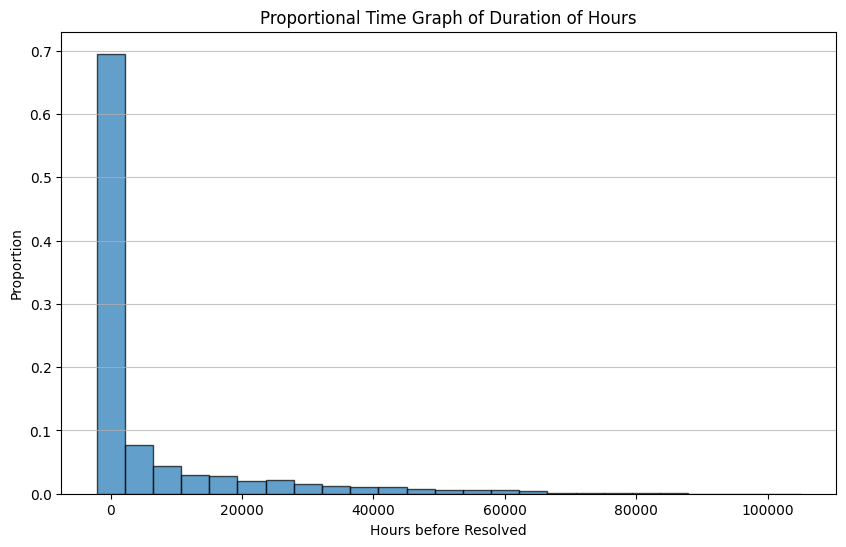

In [178]:
Graphs.TimeLabelDis(CNNtrainset)

In [154]:
MLPModelTest(CNNtestset, ['Priority', 'Emotionality','Emotion'], 'TimeLabel', model_path= 'MLPmodelTimeLabel.joblib', vectorizer_path='MLPvectorizer.joblib')

Accuracy: 0.51
F1 Score: 0.53
Precision: 0.5772330193880563
Recall: 0.51
              precision    recall  f1-score   support

        long       0.30      0.46      0.36      5110
       short       0.70      0.53      0.61     11922

    accuracy                           0.51     17032
   macro avg       0.50      0.50      0.48     17032
weighted avg       0.58      0.51      0.53     17032



In [172]:
# Restrict TensorFlow to use CPU only
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
CNNModelTest(CNNtestset, ['Emotionality','Priority','Emotion'], 'TimeLabel', model_path= 'CNNmodelFixedTime.h5', tokenizer_path='tokenizer.joblib')

533/533 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
Accuracy: 0.70
F1 Score: 0.58
Precision: 0.49
Recall: 0.70
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      5110
           1       0.70      1.00      0.82     11922

    accuracy                           0.70     17032
   macro avg       0.35      0.50      0.41     17032
weighted avg       0.49      0.70      0.58     17032



In [174]:
with tf.device('/cpu:0'):
    BerTopic(CNNtestset, 'BertTopics')

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

In [179]:
len(fulldata)

85156